# Traveling Santa Prime Paths

---
[Problem In Kaggle](https://www.kaggle.com/c/traveling-santa-2018-prime-paths/)

---

### About Dataset

---
we are provided a list of cities and their coordinates in 'cities.csv'. goal is to create the shortest possible path that visits all the cities. Output should have the ordered list in which you visit each city. 

***Paths have the following constraints***:

- Paths must start and end at the North Pole (CityId = 0)
- You must visit every city exactly once.
- The distance between two paths is the 2D Euclidean distance, except...
  - Every 10th step (stepNumber % 10 == 0) is 10% more lengthy unless coming from a prime CityId.

---

design the representation of the candidate solutions, the implementation of genetic operators (crossover/mutation), and the design of the algorithm. Report the solution of your programs.

In [55]:
# Libraries
import pandas as pd
import random
import heapq
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from itertools import chain
# from sympy import sieve

import matplotlib as mpl

print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000
print(mpl.rcParams['agg.path.chunksize'])

In [3]:
dataURL = 'https://www.cs.odu.edu/~hpendyal/courses/cs580/project/data/cities.csv'
submissionURL = 'https://www.cs.odu.edu/~hpendyal/courses/cs580/project/data/sample_submission.csv'

In [ ]:
population_size = 250
max_generations = 500

In [8]:
#import data
df=pd.read_csv(dataURL)
df.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


In [10]:
print('No of cities : ',len(df['CityId']))

No of cities :  197769


In [11]:
# using sieve of eratosthenes
def sieve_of_eratosthenes(n):
    primes = [True for i in range(n+1)] # Start assuming all numbers are primes
    primes[0] = False # 0 is not a prime
    primes[1] = False # 1 is not a prime
    for i in range(2,int(np.sqrt(n)) + 1):
        if primes[i]:
            k = 2
            while i*k <= n:
                primes[i*k] = False
                k += 1
    return(primes)
prime_cities = sieve_of_eratosthenes(max(df.CityId))

In [14]:
#--- Getting the prime city ids into seperate column isPrime
df['isPrime'] = prime_cities
df.head(11)

,CityId,X,Y,isPrime
0,0,316.836739,2202.340707,False
1,1,4377.405972,336.602082,False
2,2,3454.158198,2820.053011,True
3,3,4688.099298,2935.898056,True
4,4,1010.696952,3236.750989,False
5,5,2474.230877,1435.514651,True
6,6,1029.277795,2721.800952,False
7,7,3408.887685,199.585793,True
8,8,1304.006125,2657.427246,False
9,9,4211.525725,2294.595208,False


In [59]:
#no of prime cities
cities_prime = df[df['isPrime'] == True]
print('no of prime cities : ', len(cities_prime))

no of prime cities :  17802


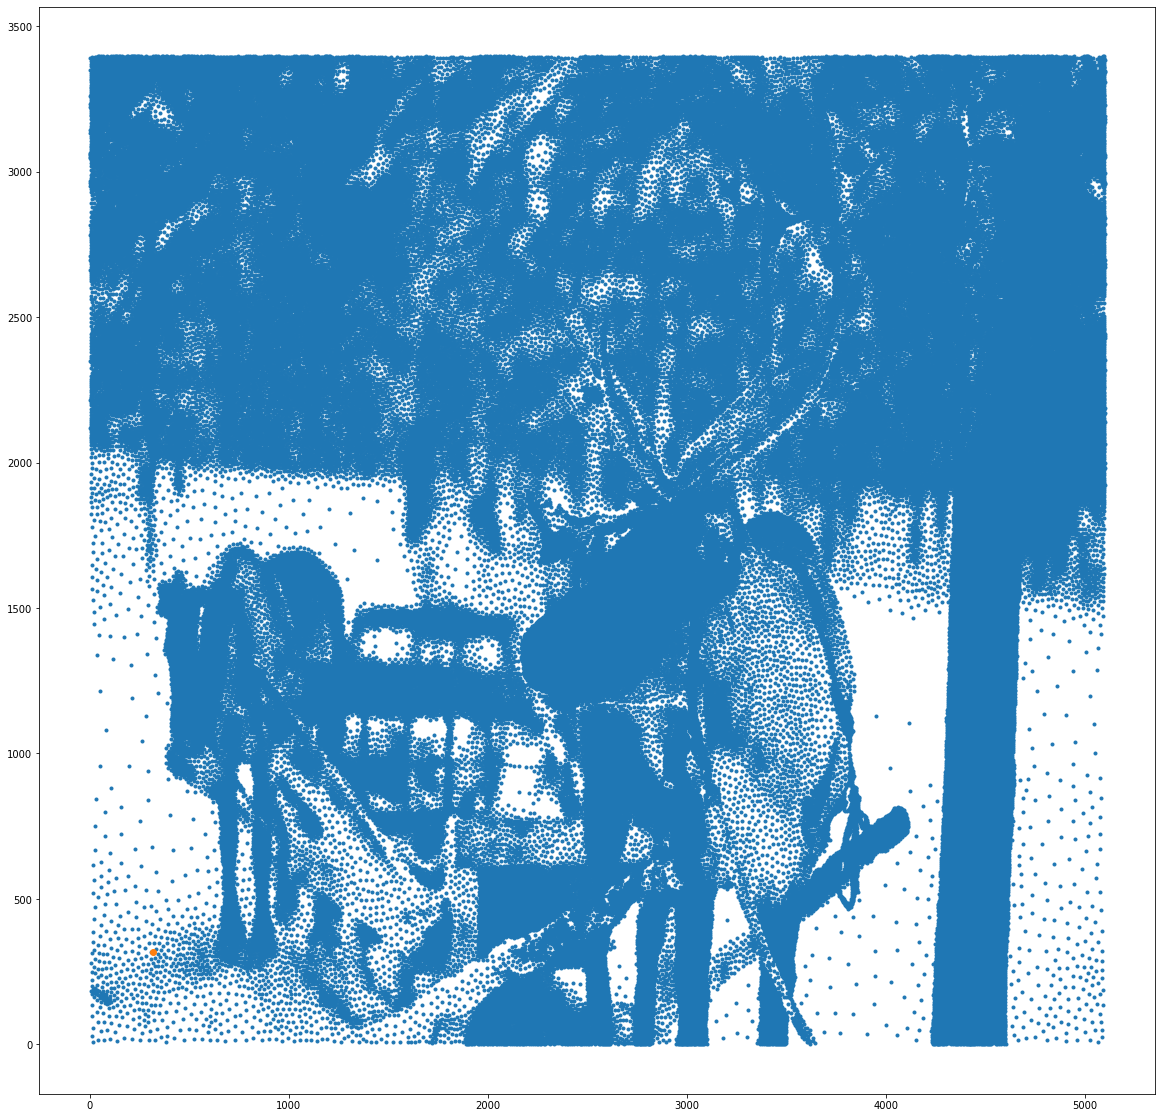

In [39]:
fig_dims = (20, 20)
fig, ax = plt.subplots(figsize=fig_dims)
plt.scatter(df['X'],df['Y'],marker='.')
plt.scatter(df[df['CityId'] == 0].X.astype(int), df[df['CityId'] == 0].X.astype(int), marker='o', cmap='red')
plt.show()

In [61]:
###--- Helper Functions
from collections import Counter
def checkIfDuplicates(listOfElems):
    ''' Check if given list contains any duplicates '''
    dct = Counter(listOfElems)
    if max(dct.values()) > 1 and (dct[0] not in [1,2]):
      return True
    else:
      return Falsedef getDataFrame(data):
  #appends 0 at end of list then convert it to dataframe
  data.extend([0])
  labelsdf = pd.DataFrame(data = data, columns=['path'])
  return labelsdf

In [62]:
def total_distance(dfcity,path):
    prev_city = path[0]
    total_distance = 0
    step_num = 1
    for city_num in path[1:]:
        next_city = city_num
        total_distance = total_distance + np.sqrt(pow((dfcity.X[city_num] - dfcity.X[prev_city]),2) + pow((dfcity.Y[city_num] - dfcity.Y[prev_city]),2)) * (1+ 0.1*((step_num % 10 == 0)*int(not(prime_cities[prev_city]))))
        prev_city = next_city
        step_num = step_num + 1
    return total_distance

In [60]:
import datetime
def saveFile(data, filename):
  savepath = './output/files/'+filename
  data.to_csv(savepath)
  print('saved file : ',filename,' at - ',savepath)

In [63]:
def getDataFrame(data):
  #appends 0 at end of list then convert it to dataframe
  data.extend([0])
  labelsdf = pd.DataFrame(data = data, columns=['path'])
  return labelsdf

### Genetic Algorithm Approach


***Algorithm***

<p align="center">
<img src="https://media1.giphy.com/media/Aid095ixEDLS8/giphy.gif?cid=790b76119037c2b2f0388fc10810a62fdf9130a0b5f7a980&rid=giphy.gif"  height="450" />


Create two classes: City and Fitness
We first create a City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. Within the City class, we add a distance calculation (making use of the Pythagorean theorem) in line 6 and a cleaner way to output the cities as coordinates with __repr__ in line 12.

In [70]:
saveimgpath = './output/images/'
cities_10 = df.head(100)
#cities_10 = cities_100[['X','Y']]
cities_10.head()

,CityId,X,Y,isPrime
0,0,316.836739,2202.340707,False
1,1,4377.405972,336.602082,False
2,2,3454.158198,2820.053011,True
3,3,4688.099298,2935.898056,True
4,4,1010.696952,3236.750989,False


In [71]:
%%time
cities_10_list = []
for i in range(0,len(cities_10)):
    cities_10_list.append((cities_10.iloc[i].X, cities_10.iloc[i].Y))

Wall time: 36.9 ms


We’ll also create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. Based on Rule #2, we need to start and end at the same place, so this extra calculation is accounted for in line 13 of the distance calculation.

In [72]:
#--- sort the cities and then apply algorithm
sorted_cities = [0]
sorted_cities_df = cities_10.iloc[1:,].sort_values(['X','Y'])
new_row = pd.DataFrame({'CityId':0,'X': cities_10.iloc[0].X, 'Y': cities_10.iloc[0].Y,'isPrime':False}, index =[0])
sorted_cities_df = pd.concat([new_row, sorted_cities_df]).reset_index(drop = True) 
temp = list(cities_10.iloc[1:,].sort_values(['X','Y']).CityId)
sorted_cities.extend(temp)
sorted_cities_df.head()

,CityId,X,Y,isPrime
0,0,316.836739,2202.340707,False
1,46,75.125822,3116.363268,False
2,73,134.054142,2631.813624,True
3,80,164.417377,3049.568364,False
4,86,297.157210,2315.592348,False


In [73]:
%%time
sorted_cities_10 = []
for i in sorted_cities:
    sorted_cities_10.append((cities_10.iloc[i].X, cities_10.iloc[i].Y))

Wall time: 33.9 ms


In [74]:
print('sorted cities : ',len(sorted_cities))
#sorted_path = [0]
dumbest_path = list(cities_10.CityId[:].append(pd.Series([0])))
sorted_path = list(sorted_cities_df.CityId[:].append(pd.Series([0])))
prime_cities_path = list(cities_prime.CityId[:])
print('unsorted Cities initial path : ',len(dumbest_path))
print('sorted Cities initial path : ',len(sorted_path))
print('Total distance with the dumbest path is '+ "{:,}".format(total_distance(cities_10,dumbest_path)))
print('Total distance with the sorted city path is '+ "{:,}".format(total_distance(cities_10,sorted_path)))
print('Total distance for prime cities : ',total_distance(cities_prime,prime_cities_path))

sorted cities :  100
unsorted Cities initial path :  101
sorted Cities initial path :  101
Total distance with the dumbest path is 214,757.18293724168
Total distance with the sorted city path is 98,857.43506286098
Total distance for prime cities :  39996421.01223912


### Plotting the path from the vertices

In [75]:
import math
import matplotlib.colors

colors = ["salmon","mediumseagreen","navyx"]

class Graph:
    def __init__(self):
      self._cities = []
      self._vertices = []
      self._city_ids = []

    def __getitem__(self, idx):
      return self._cities[idx]

    def __setitem__(self, idx, value):
      self._cities[idx] = value

    def __len__(self):
      return len(self._cities)

    def append(self, city):
      #print(city.get_city_id())
      self._cities.append(city)
      self._vertices.append(city.getVertex())
      self._city_ids.append(city.get_city_id())
        
    def get_cities(self):
      return self._cities

    def get_vertices(self):
      return self._vertices

    def get_city_ids(self):
      return self._city_ids

    @staticmethod
    def euclidean_distance(coord1, coord2):
      return math.sqrt((coord2[0] - coord1[0]) ** 2 + (coord2[1] - coord1[1]) ** 2)

    def plot(self,tour=None,text=None):
      if tour is None:
        tour = Tour(self)
      _path = [self.get_cities()[0].get_city_id()]
      _vertices = [self.get_vertices()[0]]

      for i in tour.vertices:
        _vertices.append(self.get_vertices()[i])
        _path.append(self.get_cities()[i].get_city_id())

      _vertices.append(self.get_vertices()[0])
      _path.append(self.get_cities()[0].get_city_id())
      print('vertices : ',len(_vertices))
      plt.figure(figsize=(20,20))
      plt.title("Cost = " + str(tour.fitness()))
      plt.plot(*zip(*_vertices), '-r', linewidth=1, alpha=0.3)
      plt.scatter(*zip(*self.get_vertices()), color="mediumseagreen", s=10, marker="s")
      plt.plot(cities_10['X'][0], cities_10['Y'][0], marker='x', color='navy')
      #print('vertices co-ordinates : ',_vertices)
      print('Path : ',len(_path))
      #--- save image
      dt = '{date:%Y%m%d_%H%M%S}_'.format(date=datetime.datetime.now())
      filename = dt+str(len(tour.path()))+'_'+text+'_paths.csv'
      image_name = saveimgpath+dt+str(len(_path))+'_'+text+'_paths.png'
      fig1 = plt.gcf()
      # fig1.savefig(image_name) #---- commented as giving a huge load on colab
      plt.show()
      if checkIfDuplicates(_path):
        print('ERROR !! ---- Yes, There are Duplicates')
        data_df = getDataFrame(_path)
        saveFile(data_df, filename)
        #DataFrame.to_csv(savepath+str(tour.fitness())+'_'+str(len(tour.path()))+'.txt')
      else:
        print('HURRAY!!!!---- There are NO Duplicates in the path')
        data_df = getDataFrame(tour.path())
        saveFile(data_df, filename)  

class City:
    def __init__(self, city_id, x, y):
        self._city_id = city_id
        self._x = x
        self._y = y
        self._visited = False
        self._vertex = (x,y)

    def getX(self):
        return self._x

    def getY(self):
        return self._y

    def get_city_id(self):
        return self._city_id

    def getVertex(self):
        return self._vertex

    def visit(self):
        self._visited = True

    def is_visited(self):
        return self._visited

    def __eq__(self, other):
        if not isinstance(other, type(self)):
            return False
        return self._city_id == other.get_city_id()

    def __hash__(self):
        return hash(self._city_id)

In [76]:
class Tour:
    def __init__(self, g, vertices = None):
        """Generate random tour in given graph g"""
        self.g = g
        self.__path = []
        if vertices is None:
            self.vertices = list(range(1,len(g.get_vertices())))
            #self.__path = g.get_city_ids()
            #random.shuffle(self.vertices)
        else:
            self.vertices = vertices
            #self.__path = g.get_city_ids()
        #print(self.vertices)
        self.__cost = None
        self.__fitness = None
    def path(self):
      return self.__path
    def cost(self):
        """Return total edge-cost of tour"""
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.euclidean_distance(self.g.get_vertices()[i], self.g.get_vertices()[j])
        return self.__cost
    def fitness(self):
        """Return total edge-cost of tour"""
        if self.__fitness is None:
            prev_city = 0
            step_num = 1
            self.__path.append(prev_city)
            self.__fitness = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
              next_city = j
              #print(j)
              self.__fitness += self.g.euclidean_distance(self.g.get_vertices()[i], self.g.get_vertices()[j]) * (1+ 0.1*((step_num % 10 == 0)*int(not(prime_cities[prev_city]))))
              prev_city = next_city
              self.__path.append(self.g.get_city_ids()[j])
              step_num = step_num + 1
        return self.__fitness

---- Initial prime cities Unsorted Array ----
vertices :  17803
Path :  17803


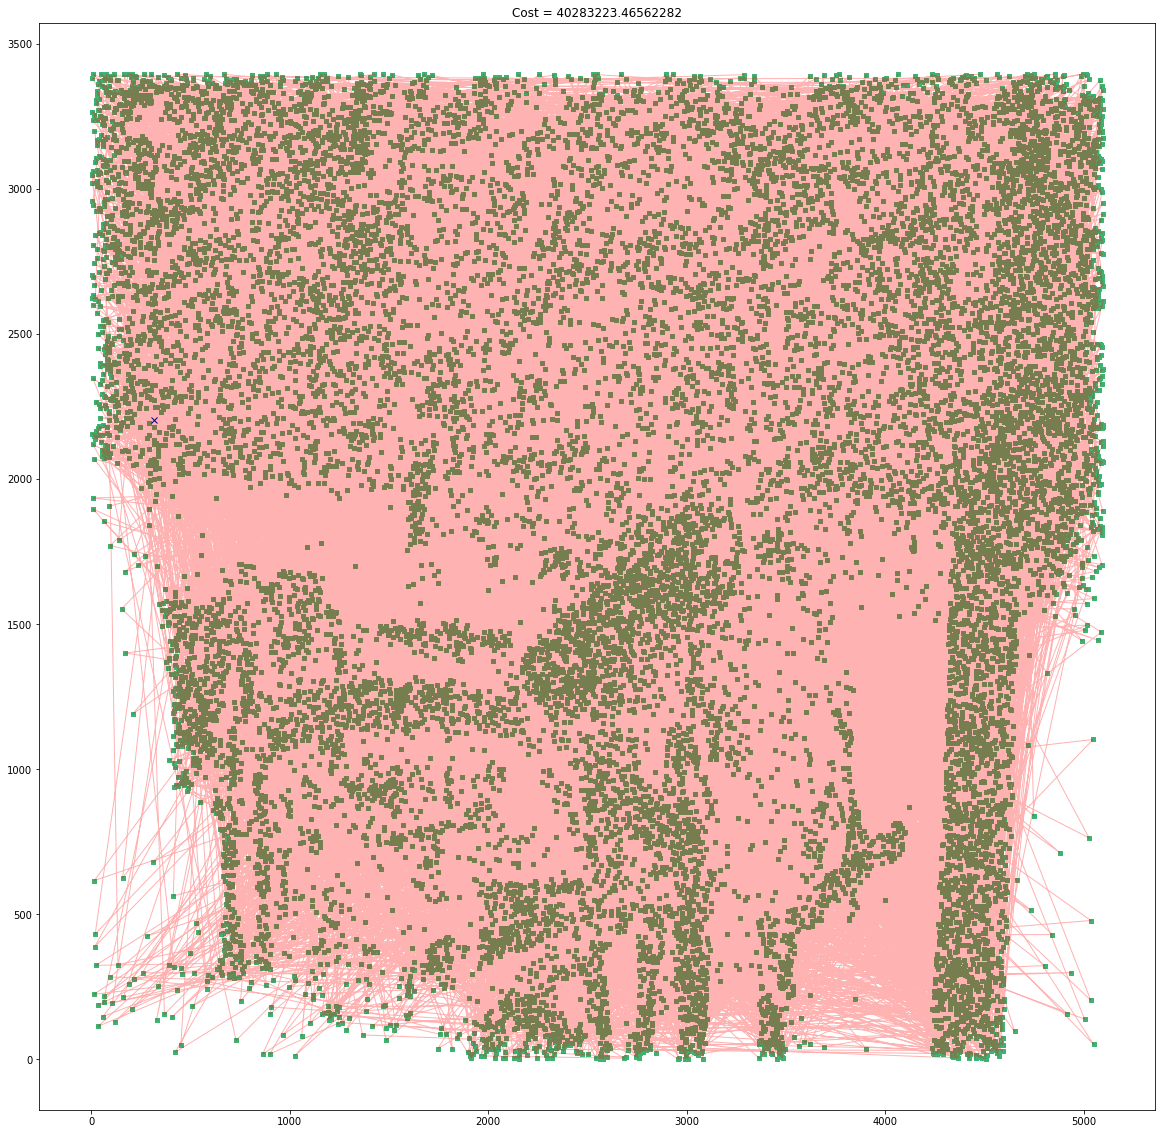

ERROR !! ---- Yes, There are Duplicates
saved file :  20191210_155609_17803_prime_cities_unsorted_paths.csv  at -  H:/Courses/CS580/project/output/files/20191210_155609_17803_prime_cities_unsorted_paths.csv
Wall time: 9.16 s


In [77]:
%%time
prime_graph = Graph()
for i in cities_prime.CityId:
  prime_graph.append(City(cities_prime['CityId'][i], cities_prime['X'][i], cities_prime['Y'][i]))
print('---- Initial prime cities Unsorted Array ----')
prime_graph.plot(text='prime_cities_unsorted')

---- Initial Unsorted Array ----
vertices :  101
Path :  101


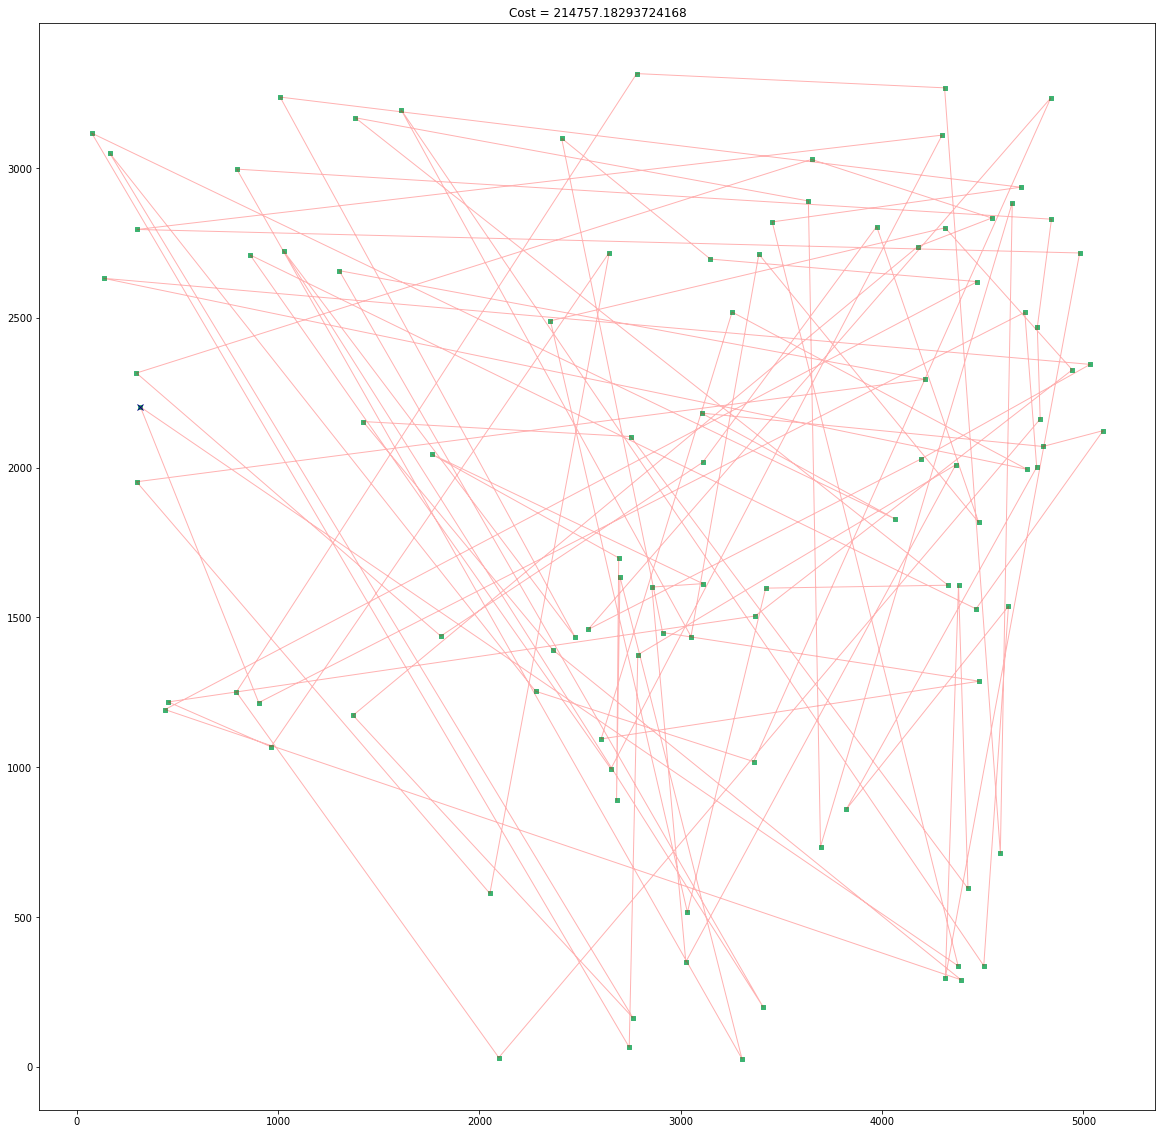

HURRAY!!!!---- There are NO Duplicates in the path
saved file :  20191210_155629_101_100000_unsorted_paths.csv  at -  H:/Courses/CS580/project/output/files/20191210_155629_101_100000_unsorted_paths.csv
Wall time: 408 ms


In [78]:
%%time
graph = Graph()
for i in range(0, len(cities_10)):
  graph.append(City(cities_10['CityId'][i], cities_10['X'][i], cities_10['Y'][i]))
print('---- Initial Unsorted Array ----')
graph.plot(text='100000_unsorted')

---- Initial sorted Array ----
vertices :  101
Path :  101


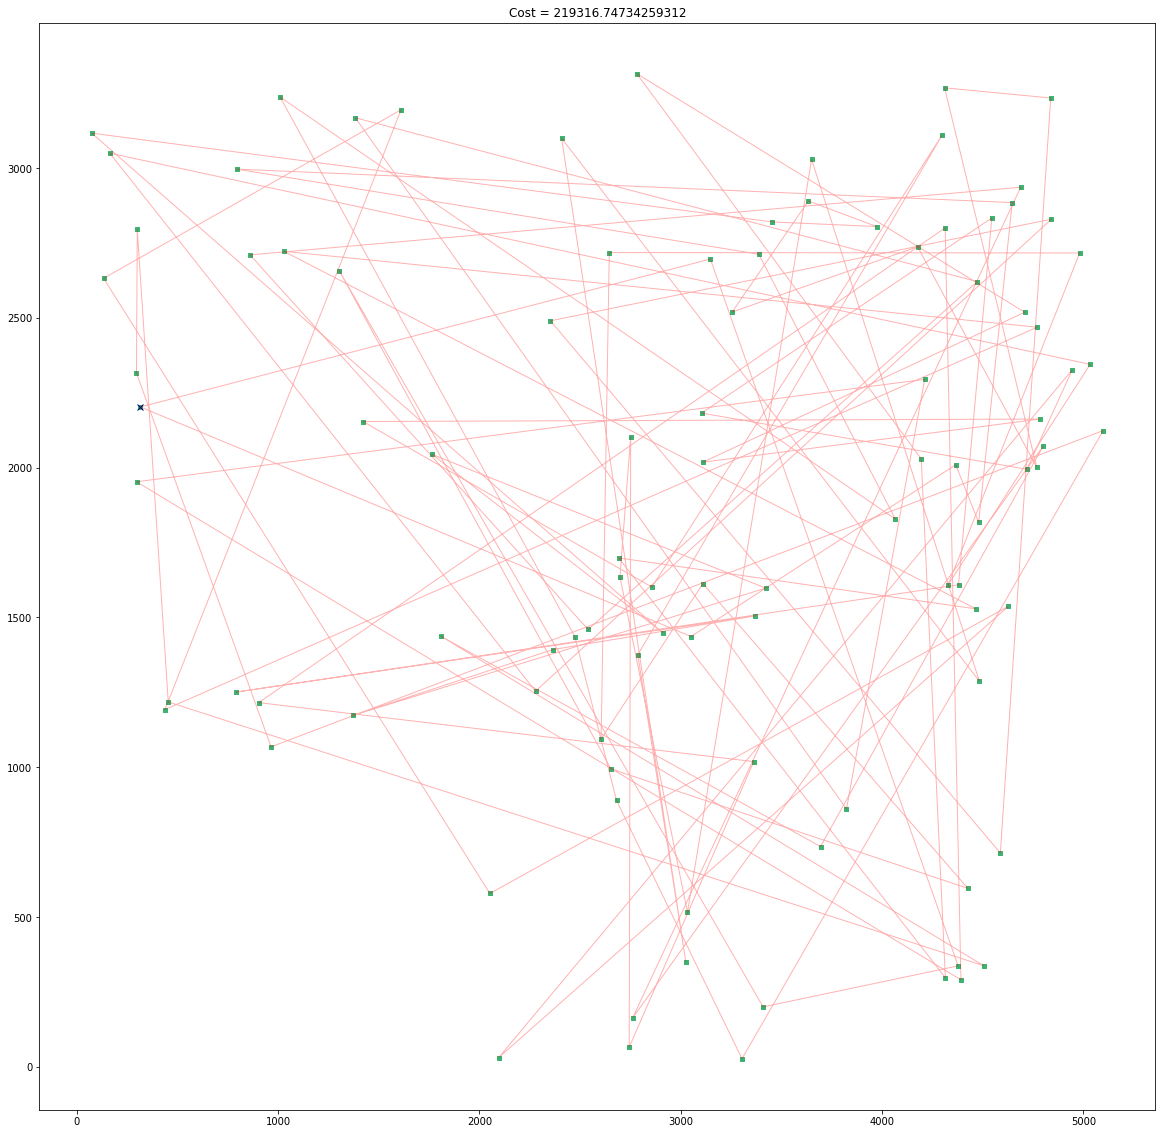

HURRAY!!!!---- There are NO Duplicates in the path
saved file :  20191210_155653_101_1000000_initial_sorted_paths.csv  at -  H:/Courses/CS580/project/output/files/20191210_155653_101_1000000_initial_sorted_paths.csv
Wall time: 371 ms


In [79]:
%%time
graph_b = Graph()
for i in sorted_cities:
  graph_b.append(City(sorted_cities_df['CityId'][i], sorted_cities_df['X'][i], sorted_cities_df['Y'][i]))
#print(graph.get_city_ids())
print('---- Initial sorted Array ----')
graph_b.plot(text='1000000_initial_sorted')

### Ordered Crossover
- Idea is to preserve the relative order that elements occur
- Procedure
    1. choose a random part from first parent
    2. copy this part to the first child
    3. Copy the numbers that are not in the first part, to the first child.
        - start right from cut point of the copied part,
        - using the order of the second parent
        - and wrapping around the end
    4. Analogous for the first child, with parent roles are reversed.

![ordered-crossover](https://www.cs.odu.edu/~hpendyal/courses/cs580/project/images/ordered-crossover-example.PNG)

In [90]:
class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        """Initialises algorithm parameters"""

        self.g = g

        self.population = []
        for _ in range(population_size):
            self.population.append(Tour(g))

        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        """Implements ordered crossover"""

        size = len(mum.vertices)

        # Choose random start/end position for crossover
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        # Replicate mum's sequence for alice, dad's sequence for bob
        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        # Fill the remaining position with the other parents' entries
        current_dad_position, current_mum_position = 0, 0

        for i in chain(range(start), range(end + 1, size)):

            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1

            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        # Return twins
        return Tour(self.g, alice), Tour(self.g, bob)

    def mutate(self, tour):
        """Randomly swaps pairs of cities in a given tour according to mutation rate"""

        # Decide whether to mutate
        if random.random() < self.mutation_rate:

            # For each vertex
            for i in range(len(tour.vertices)):

                # Randomly decide whether to swap
                if random.random() < self.mutation_swap_rate:

                    # Randomly choose other city position
                    j = random.randrange(len(tour.vertices))

                    # Swap
                    tour.vertices[i], tour.vertices[j] = tour.vertices[j], tour.vertices[i]

    def select_parent(self, k):
        """Implements k-tournament selection to choose parents"""
        tournament = random.sample(self.population, k)
        return max(tournament, key=lambda t: t.cost())

    def evolve(self):
        """Executes one iteration of the genetic algorithm to obtain a new generation"""

        new_population = []

        for _ in range(self.population_size):

            # K-tournament for parents
            mum, dad = self.select_parent(self.k), self.select_parent(self.k)
            alice, bob = self.crossover(mum, dad)

            # Mate in an elite fashion according to the elitism_rate
            if random.random() < self.elite_mating_rate:
                if alice.cost() < mum.cost() or alice.cost() < dad.cost():
                    new_population.append(alice)
                if bob.cost() < mum.cost() or bob.cost() < dad.cost():
                    new_population.append(bob)

            else:
                self.mutate(alice)
                self.mutate(bob)
                new_population += [alice, bob]

        # Add new population to old
        self.population += new_population

        # Retain fittest
        self.population = heapq.nsmallest(self.population_size, self.population, key=lambda t: t.fitness())

#--- 5000
    def run(self, iterations=max_generations):
        for _ in range(iterations):
            self.evolve()

    def best(self):
        return min(self.population, key=lambda t: t.fitness())

In [ ]:
%%time
#--- run and find the shortest distance between all prime cities
graph_p = Graph()
graph_p.append(City(cities_10['CityId'][i], cities_10['X'][i], cities_10['Y'][i]))#--- append the starting city first
for i in cities_prime.CityId:
  graph_p.append(City(cities_prime['CityId'][i], cities_prime['X'][i], cities_prime['Y'][i]))

g = graph_p

ga = GeneticAlgorithm(g,population_size)
ga.run()

best_tour = ga.best()
g.plot(best_tour, text='final_primeCities_all')

vertices :  101
Path :  101


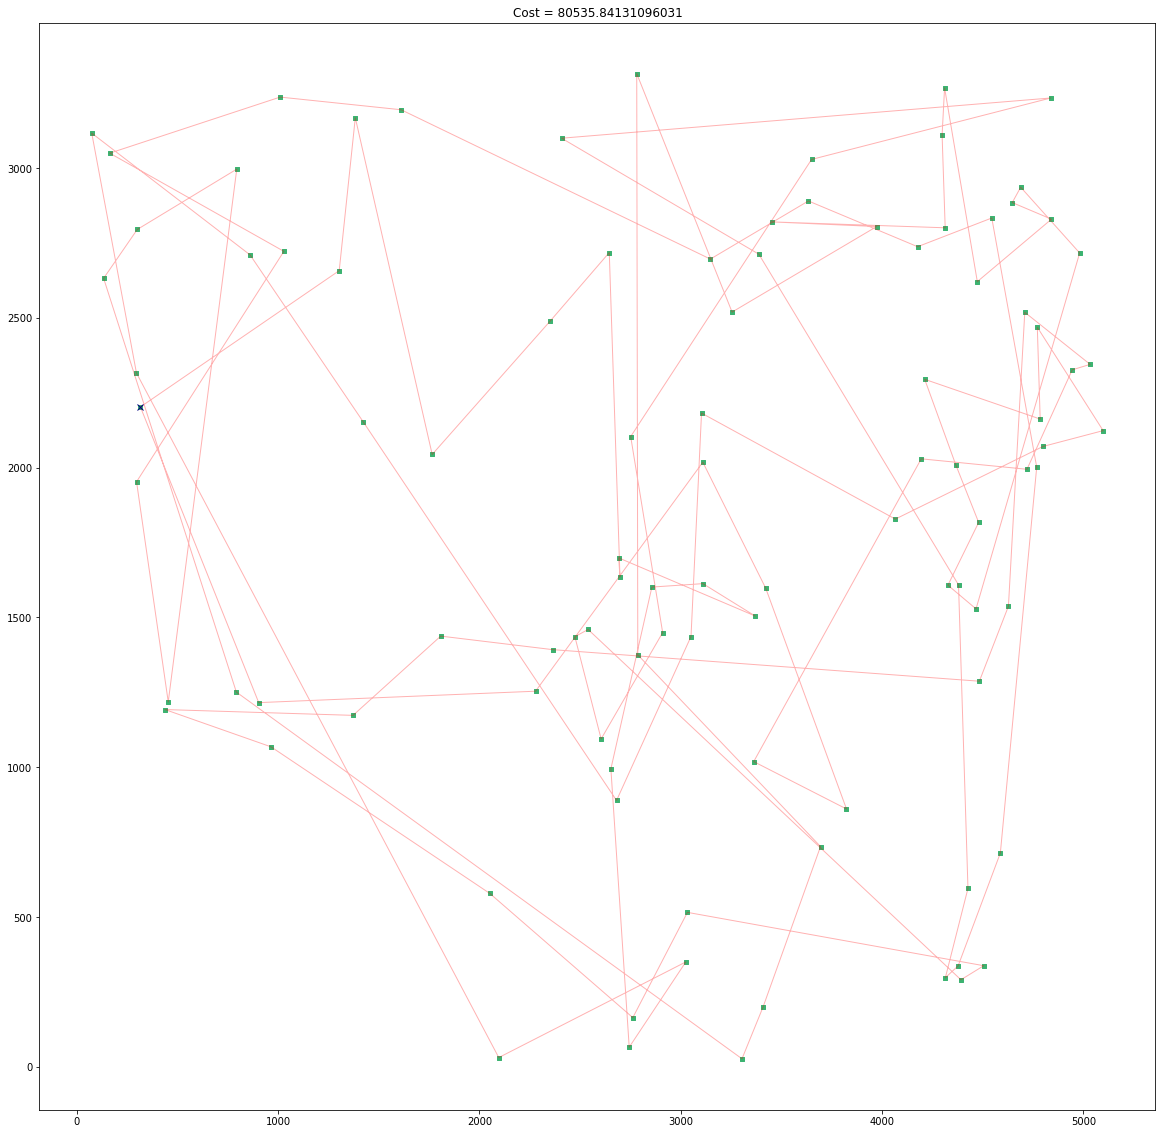

HURRAY!!!!---- There are NO Duplicates in the path
saved file :  20191210_160315_101_final_unsorted_250_500_paths.csv  at -  H:/Courses/CS580/project/output/files/20191210_160315_101_final_unsorted_250_500_paths.csv
Wall time: 1min 49s


In [86]:
%%time
#--- running on given first 10 cities
graph = Graph()
for i in range(0, len(cities_10)):
  graph.append(City(cities_10['CityId'][i], cities_10['X'][i], cities_10['Y'][i]))

g = graph

ga = GeneticAlgorithm(g, population_size)
ga.run()

best_tour = ga.best()
g.plot(best_tour, text='final_unsorted_250_500')

vertices :  101
Path :  101


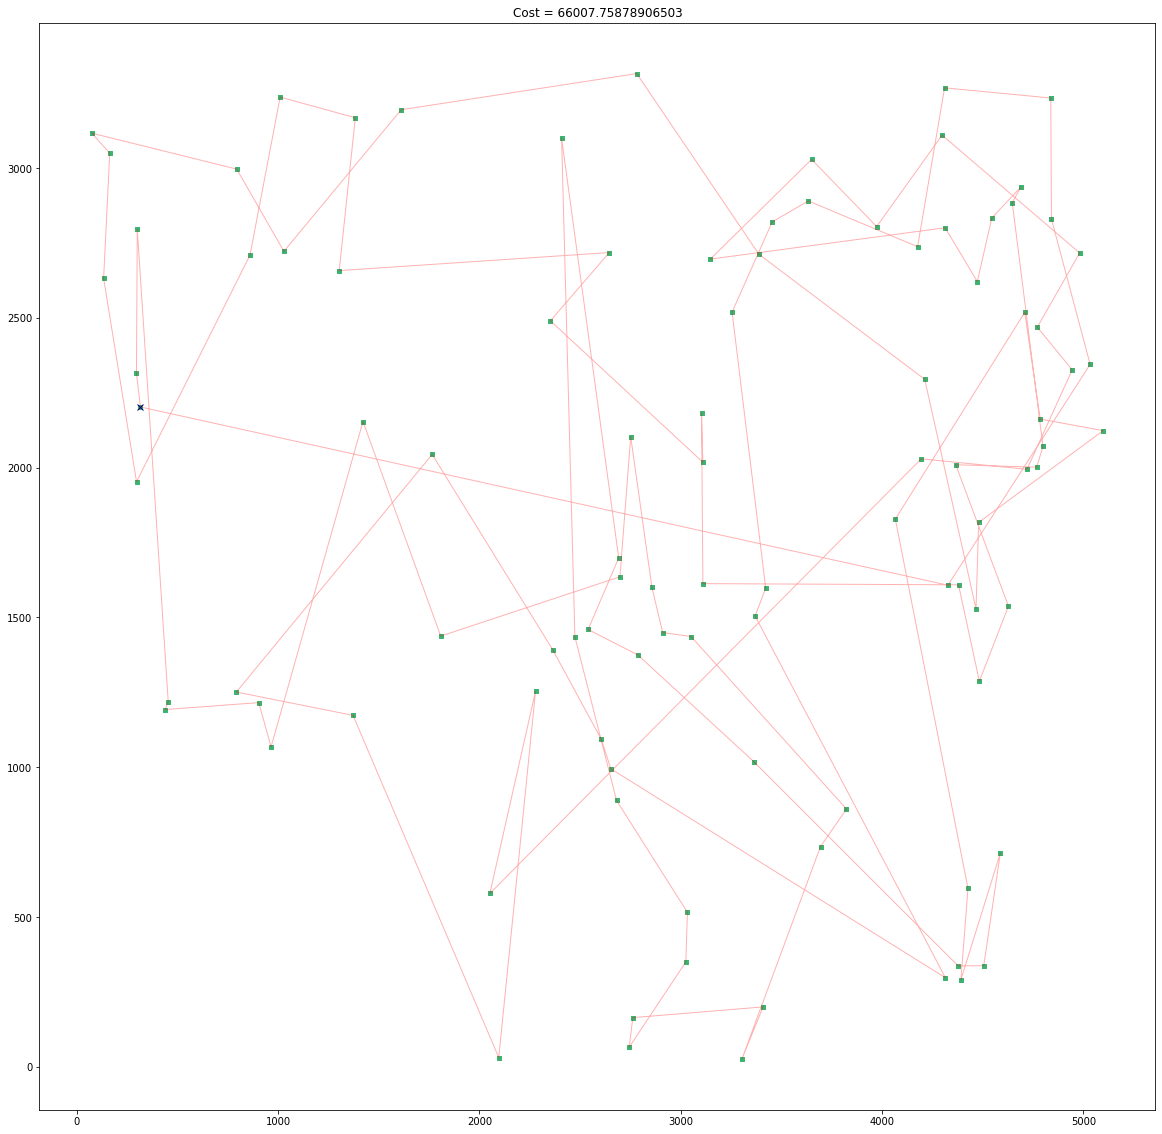

HURRAY!!!!---- There are NO Duplicates in the path
saved file :  20191210_161045_101_final_sorted_paths.csv  at -  H:/Courses/CS580/project/output/files/20191210_161045_101_final_sorted_paths.csv
Wall time: 2min 54s


In [89]:
%%time
#--- running on given first 10 sorted cities
graph = Graph()
for i in sorted_cities:
  graph.append(City(sorted_cities_df['CityId'][i], sorted_cities_df['X'][i], sorted_cities_df['Y'][i]))
g = graph

ga = GeneticAlgorithm(g, population_size)
ga.run()

best_tour = ga.best()
g.plot(best_tour, text='final_sorted')

### References
1. https://www.rookieslab.com/posts/fastest-way-to-check-if-a-number-is-prime-or-not
2. https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35